# Part 1: Understanding the data
1)	Objective of the data collection process
Objective of the data collected for this experiment was Human Activity Recognition (HAR) which aims to identify the physical actions carried out by a person by sensing human body motion using smartphone’s (Galaxy S II smartphone) sensors (accelerometer and gyroscope).

2)	There were 30 subjects (individuals) within age bracket of 19-48 years who performed Activities of Daily Living (ADL) with a waist-mounted smartphone embedded with inertial sensors in laboratory set-up. They were asked to perform 6 types of activities;
a)	Walking
b)	Walking upstairs
c)	Walking downstairs
d)	Sitting
e)	Standing
f)	Laying

3)	There are 7,352 instances (71.39%) in training dataset and 2,947 instances (28.61%) in test dataset. Each dataset has 561 features.
Features are data of triaxial (XYZ) signal collected from accelerometer and gyroscope which are prefixed by “t” representing time domain signals and “f” representing filtered signals using median filter. Acceleration signal is further separated in to body and gravity signals. Body linear and angular velocity were derived to obtain jerk signals and magnitude of these variables were calculated using Euclidean norm. After Fast Fourier Transformation (FFT) of few signals mean of these signals obtained in a single window were added.
Data contains normalized statistical measures of these signals; mean, correlation, median, IQR, correlation, max, min, standard deviation, average sum of squares, skewness, kurtosis etc.

4)	Support Vector Machine multiclass classifier One-Vs-All (OVA) with 10-fold cross validation and Gaussian kernels were used for activity recognition. Overall accuracy (hit ratio) of the model was 96% with “sitting” activity having lowest Recall (TPR) of 88%.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
##Importing datasets##
X_train = pd.read_fwf('X_train.txt', header = None)
y_train = pd.read_fwf('y_train.txt', header = None)
X_test = pd.read_fwf('X_test.txt', header = None)
y_test = pd.read_fwf('y_test.txt', header = None)

#Importing headers##
header_X = open('features.txt').read().split()[1::2]
header_y = 'Labels'

In [4]:
X_train.columns = [header_X]
X_test.columns = [header_X]
y_train.column = 'Labels'
y_test.column = 'Labels'
print('Training Data has {} instances and {} features'.format(X_train.shape[0], X_test.shape[1]))
print('Testing Data has {} instances and {} features'.format(X_test.shape[0], X_test.shape[1]))
print('Training Labels has {} instances and {} feature'.format(y_train.shape[0], y_train.shape[1]))
print('Testing Labels has {} instances and {} feature'.format(y_test.shape[0], y_test.shape[1]))

Training Data has 7352 instances and 561 features
Testing Data has 2947 instances and 561 features
Training Labels has 7352 instances and 1 feature
Testing Labels has 2947 instances and 1 feature


In [53]:
##Checking blank cells##
print('Features with empty cells in training data =',X_train.columns[X_train.isna().any()].tolist())
print('Features with empty cells in testing data =',X_test.columns[X_test.isna().any()].tolist())
print('Labels with empty cells in training data =',y_train.columns[y_train.isna().any()].tolist())
print('Labels with empty cells in testing data =',y_test.columns[y_test.isna().any()].tolist())

Features with empty cells in training data = []
Features with empty cells in testing data = []
Labels with empty cells in training data = []
Labels with empty cells in testing data = []


In [54]:
##View of top 5 observations##
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [82]:
##View of top 5 observations##
y_train.head()

,0
0,5
1,5
2,5
3,5
4,5


In [56]:
##View of top 5 observations##
X_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857


In [57]:
##View of top 5 observations##
y_test.head()

,0
0,5
1,5
2,5
3,5
4,5


In [69]:
## fID is 1, thus using accuracy as performance parameter##
fID1 = 219021675 % 2
fID1

1

# Part 2: K-Nearest Neighbour Classification

Best K = 12 with accuracy = 91.21


Text(0, 0.5, 'Cross-validated accuracy')

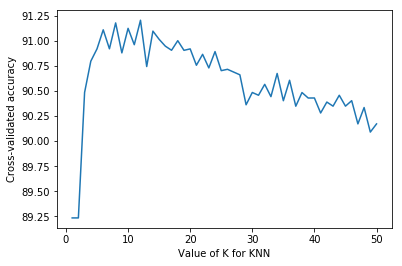

In [59]:
K_range = range(1,51)
cv_acc = []

for k in K_range:
    # 1. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    # 2. obtain cross_val_score for KNeighborsClassifier with k neighbours
    cv_score = model_selection.cross_val_score(knn, X_train, y_train.values.ravel(), cv=10, scoring='accuracy')
    # 3. append mean of scores for k neighbors to k_scores list
    cv_acc.append(cv_score.mean()*100)

print ('Best K =',cv_acc.index(max(cv_acc))+1, 'with accuracy =',round(max(cv_acc),2))
plt.plot(K_range, cv_acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [60]:
##KNN with best K##
bestK = int(cv_acc.index(max(cv_acc))+1)
bestK

knn_model = KNeighborsClassifier(n_neighbors= bestK, weights = 'distance')
knn_model.fit(X_train, y_train.values.ravel())

## Training accuracy with best K##
knn_train_acc = metrics.accuracy_score(y_train, knn_model.predict(X_train))
print ("KNN Training Accuracy: {}".format(knn_train_acc))

#Fitting model and deriving accuracy on test data with best k##
knn_test_acc = metrics.accuracy_score(y_test, knn_model.predict(X_test))
print ("KNN Testing Accuracy: {}".format(knn_test_acc))

knn_con_mat = metrics.confusion_matrix(y_test,knn_model.predict(X_test))
print ("KNN Confusion matrix:\n",knn_con_mat)

knn_class_avg = metrics.classification_report(y_test,knn_model.predict(X_test))
print ("KNN Multiclass F1 score and accuracy:\n",knn_class_avg)

KNN Training Accuracy: 1.0
KNN Testing Accuracy: 0.9036308109942314
KNN Confusion matrix:
 [[484   2  10   0   0   0]
 [ 37 425   9   0   0   0]
 [ 43  42 335   0   0   0]
 [  0   4   0 388  99   0]
 [  0   0   0  35 497   0]
 [  0   0   0   2   1 534]]
KNN Multiclass F1 score and accuracy:
               precision    recall  f1-score   support

           1       0.86      0.98      0.91       496
           2       0.90      0.90      0.90       471
           3       0.95      0.80      0.87       420
           4       0.91      0.79      0.85       491
           5       0.83      0.93      0.88       532
           6       1.00      0.99      1.00       537

   micro avg       0.90      0.90      0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947



# Part 3: Multiclass Logistic Regression with Elastic Net

In [70]:
## fID is 1, thus using f1-score as performance parameter##
fID2 = 219021675 % 2
fID2

1

In [61]:
##Dictionary of parameters##
params = {'alpha':[1e-4,3e-4,1e-3,3e-3, 1e-2,3e-2], 'l1_ratio':[0,0.15,0.5,0.7,1]}

##Fitting model##
log_reg = SGDClassifier(loss= 'log', penalty='elasticnet')
grid = model_selection.GridSearchCV(log_reg, params, cv = 10, scoring = 'f1_weighted')
grid.fit(X_train, y_train.values.ravel())

#Accuracy measures##
print('Weighted_f1_score:', round(grid.best_score_,3))
Best_alpha =grid.best_params_['alpha']
Best_l1_ratio = grid.best_params_['l1_ratio']
print ('Best Alpha:',Best_alpha)
print ('Best l1_ratio:',Best_l1_ratio)

Weighted_f1_score: 0.94
Best Alpha: 0.001
Best l1_ratio: 0.15


Alpha values 
         0       1       2       3       4       5       6       7       8   \
0   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
1   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
2   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
3   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
4   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
5   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
6   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
7   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
8   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
9   0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
10  0.0001  0.0001  0.0001  0.0001  0.0001  0.0003  0.0003  0.0003  0.0003   
11  0.0001  0.0001  0.0001  0.0001  0.0001  0.000

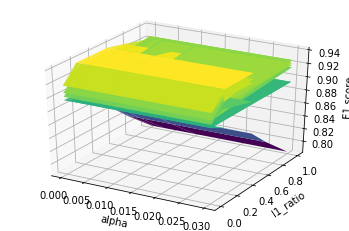

In [131]:
##Surface plot of F1 score w.r.t. alpha and L1-ratio

F1_scores = pd.DataFrame.from_dict(grid.cv_results_['mean_test_score'])
alpha_new = pd.DataFrame.from_dict(grid.cv_results_['param_alpha'])
l1_ratio_new = pd.DataFrame.from_dict(grid.cv_results_['param_l1_ratio'])

fig = plt.figure()
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(alpha_new,l1_ratio_new)
Z = F1_scores
print(f"Alpha values \n {pd.DataFrame(X)}")
print(f"\nL1_ratio values \n {pd.DataFrame(Y)}")
print(f"\nF1 scores \n {pd.DataFrame(Z)}")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel("alpha")
ax.set_ylabel("l1_ratio")
ax.set_zlabel("F1 score")
plt.show()

# SGDC Graph interpretation
There is negative relationship between hyperparameters (alpha and l1 ratio) and F1 score. It seems, alpha affects F1 score more than l1 ratio. As alpha increase F1 score decreases, F1 score increases till 0.15 l1 ratio and drops beyond that. Thus, alpha is important variable and should be less than 0.001 and 1 ratio should be less than 0.15.

In [63]:
##Model on test dataset with best alpha and L1-ratio##
SGD_model = SGDClassifier(loss='log', penalty='elasticnet', alpha=Best_alpha, l1_ratio=Best_l1_ratio, max_iter=1000) 
SGD_model.fit(X_train, y_train.values.ravel())

#Training accuracy
SGD_acc_train= metrics.accuracy_score(y_train, SGD_model.predict(X_train))
print ("SGD Training Accuracy: {}".format(SGD_acc_train))

#Fitting model on test data##
SGD_test_acc = metrics.accuracy_score(y_test, SGD_model.predict(X_test))
print ("SGD Testing Accuracy: {}".format(SGD_test_acc))

SGD_con_mat = metrics.confusion_matrix(y_test,SGD_model.predict(X_test))
print ("SGD Confusion matrix:\n",SGD_con_mat)

SGD_class_avg = metrics.classification_report(y_test,SGD_model.predict(X_test))
print ("SGD Multiclass F1 score and accuracy:\n",SGD_class_avg)


SGD Training Accuracy: 0.9816376496191512
SGD Testing Accuracy: 0.9569053274516457
SGD Confusion matrix:
 [[491   0   5   0   0   0]
 [ 21 444   6   0   0   0]
 [  7  12 401   0   0   0]
 [  0   3   0 436  52   0]
 [  2   0   0  19 511   0]
 [  0   0   0   0   0 537]]
SGD Multiclass F1 score and accuracy:
               precision    recall  f1-score   support

           1       0.94      0.99      0.97       496
           2       0.97      0.94      0.95       471
           3       0.97      0.95      0.96       420
           4       0.96      0.89      0.92       491
           5       0.91      0.96      0.93       532
           6       1.00      1.00      1.00       537

   micro avg       0.96      0.96      0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



# Part 4: Support Vector Machine (RBF Kernel)

In [71]:
## fID is 0, thus using f1-score as performance parameter##
fID3 = 219021675 % 3
fID3

0

In [64]:
##Dictionary of parameters##
SVM_params = {'gamma':[1e-3,1e-4], 'C':[1,10,100,1000]}

##Fitting model##
SVM_model = svm.SVC(kernel = 'rbf')
SVM_grid = model_selection.GridSearchCV(SVM_model, SVM_params, cv = 10, scoring = 'f1_weighted')
SVM_grid.fit(X_train, y_train.values.ravel())

#Accuracy measures##
print('Weighted_f1_score:', round(SVM_grid.best_score_,3))
Best_gamma =SVM_grid.best_params_['gamma']
Best_C = SVM_grid.best_params_['C']
print ('Best Gamma:',Best_gamma)
print ('Best Cost penalty:',Best_C)

Weighted_f1_score: 0.951
Best Gamma: 0.001
Best Cost penalty: 1000


Gamma 
        0       1      2       3      4       5      6       7
0  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
1  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
2  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
3  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
4  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
5  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
6  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001
7  0.001  0.0001  0.001  0.0001  0.001  0.0001  0.001  0.0001

Cost 
       0     1     2     3     4     5     6     7
0     1     1     1     1     1     1     1     1
1     1     1     1     1     1     1     1     1
2    10    10    10    10    10    10    10    10
3    10    10    10    10    10    10    10    10
4   100   100   100   100   100   100   100   100
5   100   100   100   100   100   100   100   100
6  1000  1000  1000  1000  1000  1000  1000  1000
7  1000  1000  1000  1000 

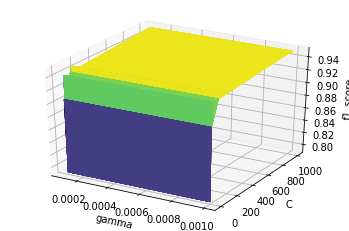

In [136]:

##Surface plot of F1 score w.r.t. gamma and C

SVM_f1_score = pd.DataFrame.from_dict(SVM_grid.cv_results_['mean_test_score'])
gamma_new = pd.DataFrame.from_dict(SVM_grid.cv_results_['param_gamma'])
C_new = pd.DataFrame.from_dict(SVM_grid.cv_results_['param_C'])

fig = plt.figure()
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(gamma_new,C_new)
Z = SVM_f1_score
print(f"Gamma \n {pd.DataFrame(X)}")
print(f"\nCost \n {pd.DataFrame(Y)}")
print(f"\nF1 scores \n {pd.DataFrame(Z)}")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel("gamma")
ax.set_ylabel("C")
ax.set_zlabel("f1_score")
plt.show()

# SVM graph interpretation
Both the hyperparameters equally affect F1 score. Both the hyperparameters has positive relationship with F1 score. As cost and gamma increases, F1 score increases, thus best F1 score is when C is max (0.001) and gamma is max (1000).

In [66]:
##Model on test dataset with best gamma and C##
SVM_model1 = svm.SVC(C = Best_C, kernel = 'rbf', gamma = Best_gamma)
SVM_model1.fit(X_train, y_train.values.ravel())

#Training accuracy
SVM_acc_train= metrics.accuracy_score(y_train, SVM_model1.predict(X_train))
print ("SVM Training Accuracy: {}".format(SVM_acc_train))

#Fitting model on test data##
SVM_test_acc = metrics.accuracy_score(y_test, SVM_model1.predict(X_test))
print ("SVM Testing Accuracy: {}".format(SVM_test_acc))

SVM_con_mat = metrics.confusion_matrix(y_test,SVM_model1.predict(X_test))
print ("SVM Confusion matrix:\n",SVM_con_mat)

SVM_class_avg = metrics.classification_report(y_test,SVM_model1.predict(X_test))
print ("SVM Multiclass F1 score and accuracy:\n",SVM_class_avg)

SVM Training Accuracy: 0.9971436343852013
SVM Testing Accuracy: 0.9647098744485918
SVM Confusion matrix:
 [[491   0   5   0   0   0]
 [ 17 453   1   0   0   0]
 [  3  10 407   0   0   0]
 [  0   2   0 435  54   0]
 [  0   0   0  12 520   0]
 [  0   0   0   0   0 537]]
SVM Multiclass F1 score and accuracy:
               precision    recall  f1-score   support

           1       0.96      0.99      0.98       496
           2       0.97      0.96      0.97       471
           3       0.99      0.97      0.98       420
           4       0.97      0.89      0.93       491
           5       0.91      0.98      0.94       532
           6       1.00      1.00      1.00       537

   micro avg       0.96      0.96      0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.97      0.96      0.96      2947



# Part 5: Random Forest

In [72]:
## fID is 0, thus using recall as performance parameter##
fID4 = 219021675 % 4
fID4

3

In [121]:
##Dictionary of parameters##
RFC_params = {'n_estimators':[200,500,700], 'max_depth':[300,500,600]}
score = ['f1_weighted', 'recall_weighted']
##Fitting model##
RFC_model = RandomForestClassifier(random_state = 50)

In [122]:
##Fitting model
RFC_grid= model_selection.GridSearchCV(RFC_model, RFC_params, cv = 10, scoring = score, refit = 'recall_weighted')
RFC_grid.fit(X_train, y_train.values.ravel())  

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500, 700], 'max_depth': [300, 500, 600]},
       pre_dispatch='2*n_jobs', refit='recall_weighted',
       return_train_score='warn',
       scoring=['f1_weighted', 'recall_weighted'], verbose=0)

Number of Trees 
      0    1    2    3    4    5    6    7    8
0  200  500  700  200  500  700  200  500  700
1  200  500  700  200  500  700  200  500  700
2  200  500  700  200  500  700  200  500  700
3  200  500  700  200  500  700  200  500  700
4  200  500  700  200  500  700  200  500  700
5  200  500  700  200  500  700  200  500  700
6  200  500  700  200  500  700  200  500  700
7  200  500  700  200  500  700  200  500  700
8  200  500  700  200  500  700  200  500  700

Tree Depth 
      0    1    2    3    4    5    6    7    8
0  300  300  300  300  300  300  300  300  300
1  300  300  300  300  300  300  300  300  300
2  300  300  300  300  300  300  300  300  300
3  500  500  500  500  500  500  500  500  500
4  500  500  500  500  500  500  500  500  500
5  500  500  500  500  500  500  500  500  500
6  600  600  600  600  600  600  600  600  600
7  600  600  600  600  600  600  600  600  600
8  600  600  600  600  600  600  600  600  600

F1 scores 
        0
0  92.

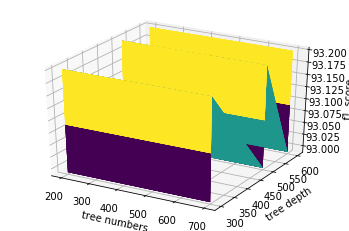

In [123]:
##Plotting F1 score w.r.t. number of trees and depth of the tree
RFC_f1_score = pd.DataFrame.from_dict(RFC_grid.cv_results_['mean_test_f1_weighted'])
tree_num_new = pd.DataFrame.from_dict(RFC_grid.cv_results_['param_n_estimators'])
tree_depth_new = pd.DataFrame.from_dict(RFC_grid.cv_results_['param_max_depth'])

fig = plt.figure()
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(tree_num_new,tree_depth_new)
Z = round(RFC_f1_score*100,2)
print(f"Number of Trees \n {pd.DataFrame(X)}")
print(f"\nTree Depth \n {pd.DataFrame(Y)}")
print(f"\nF1 scores \n {pd.DataFrame(Z)}")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')
ax.set_xlabel("tree numbers")
ax.set_ylabel("tree depth")
ax.set_zlabel("f1_score")
plt.show()

# RFC Graph interpretation
Number of trees has more effect on F1 score. At 200 number of trees, F1 score reduces irrespective of increment in tree depth. As number of trees increases, F1 score increases at each level of tree depth, i.e. if tree depth 300, then F1 score increases as number of trees increases from 200 to 700.

In [124]:
#Accuracy measures##
print('Best Recall Score:', round(RFC_grid.best_score_,3))
Best_tree_num =RFC_grid.best_params_['n_estimators']
Best_tree_dep = RFC_grid.best_params_['max_depth']
print ('Optimal trees:',Best_tree_num)
print ('Optimal tree depth:',Best_tree_dep)

Best Recall Score: 0.933
Optimal trees: 700
Optimal tree depth: 300


In [125]:
##Model on test dataset with best trees and tree depth
RFC_model1 = RandomForestClassifier(n_estimators = Best_tree_num, max_depth = Best_tree_dep, random_state = 60 )
RFC_model1.fit(X_train, y_train.values.ravel())

#Training accuracy
RFC_acc_train= metrics.accuracy_score(y_train, RFC_model1.predict(X_train))
print ("RFC Training Accuracy: {}".format(RFC_acc_train))

#Fitting model on test data##
RFC_test_acc = metrics.accuracy_score(y_test, RFC_model1.predict(X_test))
print ("RFC Testing Accuracy: {}".format(RFC_test_acc))

RFC_con_mat = metrics.confusion_matrix(y_test,RFC_model1.predict(X_test))
print ("RFC Confusion matrix:\n",RFC_con_mat)

RFC_class_avg = metrics.classification_report(y_test,RFC_model1.predict(X_test))
print ("RFC Multiclass F1 score and accuracy:\n",RFC_class_avg)

RFC Training Accuracy: 1.0
RFC Testing Accuracy: 0.9260264675941635
RFC Confusion matrix:
 [[481   5  10   0   0   0]
 [ 30 435   6   0   0   0]
 [ 20  46 354   0   0   0]
 [  0   0   0 438  53   0]
 [  0   0   0  48 484   0]
 [  0   0   0   0   0 537]]
RFC Multiclass F1 score and accuracy:
               precision    recall  f1-score   support

           1       0.91      0.97      0.94       496
           2       0.90      0.92      0.91       471
           3       0.96      0.84      0.90       420
           4       0.90      0.89      0.90       491
           5       0.90      0.91      0.91       532
           6       1.00      1.00      1.00       537

   micro avg       0.93      0.93      0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



# Part 6: Discussion
1)	Since target labels are not highly unbalanced, I have used accuracy (hit ratio) as the parameter across training and test dataset to compare different classifiers. As mentioned in the research paper, SVM is the best classifier with hit ratio of 96.47% and it is observed that sitting has lowest recall of 89% on test dataset. SGDC is next best classifier with hit ratio of 95.76% and even it has lowest recall of 89% for sitting activity on test dataset. KNN has lowest hit ratio of 90.36%. RFC has accuracy of 92.60%. SVM has three hyperparameters to fine tune the model, gamma, cost, and kernel which takes care non-linearity robustly. Thus, it has performed better than other classifiers.

2)	 KNN and RFC has 100% accuracy on Training set but performed poor on Test set. Thus, we can say that KNN and RFC suffered from overfitting issue. KNN performance was worst as it has only one hyperparameter “K” to fine tune the model, whereas other classifiers have at least two hyperparameters (3 in case of SVM) to fine tune the model.

3)	To improve KNN, I think we should add one more hyperparameter. I used “distance” as weights. Maybe we can try another weight as algorithm accepts user-defined weights. For, we can use post-pruning and then compare the performance.
